# W207 Final Project
Erika, Jen Jen, Geoff, Leslie

(In Python 3)

As of 3/35

Outline:

* Data Pre-Processing  
* Simple Feature Selection
* Basline Models
* Possible Approaches
   

# Section 1 Loading and Processing Data

In [9]:
## Import Libraries ##
import json
from pprint import pprint
from pandas import *
from pandas.io.json import json_normalize


# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import mlxtend
import scipy

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
## Get Data ##

#reference on data: https://www.kaggle.com/c/random-acts-of-pizza/data
# pull in the training and test data
with open('/Users/erikaananda/Documents/MIDS/W207/Final Project/data/train.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   
with open('/Users/erikaananda/Documents/MIDS/W207/Final Project/data/test.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]


# create a normalized view
allTData = json_normalize(trainData)
print("\nSize of the normalized Data:", allTData.shape)
print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)



Size of the normalized Data: (3040, 32)

normalized data columns: ['giver_username_if_known', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subreddits_at_request', 'requester_received_pizza', 'requester_subreddits_at_request

In [3]:
## Create subsets of data for analysis ###

# create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# create a separate dataset with just subreddits, indexed on request id
# we can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# what do these look like?
#print(list(flatData))
print(subredTData.shape)
#print(subredTData['requester_subreddits_at_request'][1])

# create a corpus of subreddits to vectorize
trainCorpus = []
rTCorpus = []
rDCorpus = []

for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))
    rTCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    rDCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))

    # baseline info
print("Percent of people who got pizza:", round(sum(trainLabel)/len(trainLabel),3))




(3040, 1)
Percent of people who got pizza: 0.241


In [4]:
# combine all text sources into a single corpus
fldTText = allTData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]
fldDText = allDData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]

trainCorpus = []
for index in range(len(subredTData)):
    a = ' '.join(subredTData['requester_subreddits_at_request'][index])
    b = (a, fldTText['request_text'][index], fldTText['request_text_edit_aware'][index],
        fldTText['request_title'][index])
    trainCorpus.append(' '.join(b))

devCorpus = []
for index in range(len(subredDData)):
    a = ' '.join(subredDData['requester_subreddits_at_request'][index])
    b = (a, fldDText['request_text'][index], fldDText['request_text_edit_aware'][index],
         fldDText['request_title'][index])
    devCorpus.append(' '.join(b))

# Print 3 examples  
print (trainCorpus[:1])
labels = trainLabel.astype(int)
labels = list(labels)
print(labels[:1])
print('-'*75)

print ('\n' , devCorpus[:1])
labels_dev = devLabel.astype(int)
labels_dev = list(labels_dev)
print(labels_dev[:1])

["FoodstuffsAllAround IAmA RandomActsOfCookies RandomActsofCards RandomKindness Random_Acts_Of_Pizza comiccon cosplay cosplayers So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now... So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now... [Request] Just got dumped, no food in the freezer. Pizza?"]
[0]
---------------------------------------------------------------------------

 [' Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated Hi I am in need

# Section 2. Simple Feature Selection and Pre-Processing

In [5]:
# Simple Pre-Processing

def data_preprocessor(s):
    """
    Note: this function pre-processors data:
    (1) removes non-alpha characters
    (2) converts digits to 'number'
    (3) regularizes spaces (although CountVectorizer ignores this unless they are part of words)
    (4) reduces word size to n
    """

    s = [re.sub(r'[?|$|.|!|@|\n|(|)|<|>|_|-|,|\']',r' ',s) for s in s] # strip out non-alpha numeric char, replace with space
    s = [re.sub(r'\d+',r'number ',s) for s in s] # convert digits to number
    s = [re.sub(r' +',r' ',s) for s in s] # convert multiple spaces to single space
    
    # This sets word size to n=5
    num = 5
    def set_word(s):
        temp = []
        for s in s:
            x = s.split()
            z = [elem[:num] for elem in x]
            z = ' '.join(z)
            temp.append(z)       
        return temp
    
    s = set_word(s)
    
    return s



In [6]:
stop = {'I','about', 'a', 'an', 'are', 'as', 'at', 'be', 'by', 'com', 'for', 'from', 'how',
        'in','is','it','of','on','or','that','the','this','to','was','what','when','where',
        'who','will', 'with', 'the','www'}


## Section 2.1 BiGrams 
After trying unigram and trigram vectorizers, the best results were found using bigrams in logistic regression


In [8]:
# try it with bigrams 
# create the vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(2, 2), 
                                token_pattern=r'\b\w+\b', min_df=1,stop_words = stop)
# transform the corpus into vectorized trigrams
tVector = vectorizer.fit_transform(trainCorpus)
dVector = vectorizer.transform(data_preprocessor(devCorpus))
# how does it look?
print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")
# use the preprocessor and do the same
vectorizer_p = CountVectorizer(analyzer = 'word', ngram_range=(2, 2), 
                                  token_pattern=r'\b\w+\b', min_df=1,stop_words = stop)
tVector_p = vectorizer_p.fit_transform(data_preprocessor(trainCorpus))
dVector_p = vectorizer_p.transform(data_preprocessor(devCorpus))
# how does the pre-processed vector look?
print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector_p.shape[1])
print ("First 5 feature Names:", vectorizer_p.get_feature_names()[1:6], "\n")



Raw data:
The size of the vocabulary for the training text data is 125687
First 5 feature Names: ['0 00', '0 00243364', '0 012468', '0 02', '0 024856'] 


Raw data:
The size of the vocabulary for the training text data is 116681
First 5 feature Names: ['aa meeti', 'aaaaa actua', 'aaaaa adven', 'aaaaa agnos', 'aaaaa ainbo'] 



## Section 2.2 PCA

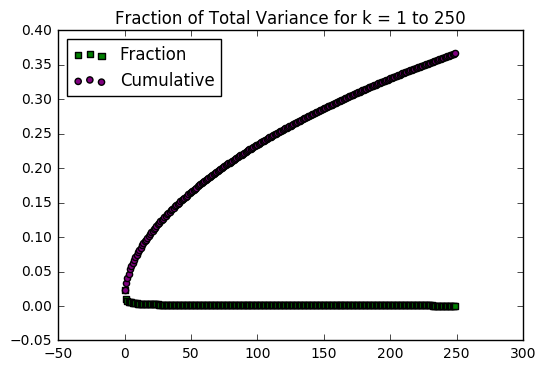

In [22]:
# try PCA

# k = 250 principal components    
n_comp = 250    
pca_mod = PCA(n_components = n_comp)
# PCA requires dense vectors:
tDense = tVector_p.todense()
# get the principal components for the dense vector
pca_mod.fit(tDense)
# find the fraction of the variance explained by each component
pcaVarRatio =  pca_mod.explained_variance_ratio_ 
pcaCumVarRatio =  np.cumsum(pca_mod.explained_variance_ratio_)
   
# plot the fraction of variance explained by each component, and the cumulative percent 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(range(len(pcaVarRatio)), pcaVarRatio, c = 'g', marker="s", label='Fraction')
ax1.scatter(range(len(pcaVarRatio)), pcaCumVarRatio, c = 'purple',marker="o", 
            label='Cumulative')
plt.legend(loc='upper left');
ax1.set_title('Fraction of Total Variance for k = 1 to 250');
plt.show()

# Section 3. Baseline Models

## Logistic Regression

In [23]:
# Logistic Regression: bigrams
# fit a logistic regression model to our bigrams, using l2 regularization and C = .5
c = .01
modelLogit = LogisticRegression(penalty='l2', C=c)
modelLogit.fit(tVector, trainLabel)

# print out the classification report
print("Classification report raw bigrams:\n")
devPred = modelLogit.predict(dVector)
print(classification_report(devLabel, devPred))

# print out the accuracy scode   
logitScore = round(modelLogit.score(dVector, devLabel), 4)
print("For C = ", c, "Logistic regression accuracy:", logitScore)

#fit the pre-processed data
modelLogit_p = LogisticRegression(penalty='l2', C=c)
modelLogit_p.fit(tVector_p, trainLabel)

# print out the classification report
print("\nClassification report processed bigrams:\n")
devPred = modelLogit_p.predict(dVector_p)
print(classification_report(devLabel, devPred))
    
# print the accuracy score
logitScore = round(modelLogit_p.score(dVector_p, devLabel), 4)
print("For C = ", c, "Logistic regression accuracy:", logitScore)

Classification report raw bigrams:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

For C =  0.01 Logistic regression accuracy: 0.739

Classification report processed bigrams:

             precision    recall  f1-score   support

      False       0.75      1.00      0.85       740
       True       1.00      0.03      0.07       260

avg / total       0.81      0.75      0.65      1000

For C =  0.01 Logistic regression accuracy: 0.749


## Ensemble Model on PCA Features

In [24]:
# create an ensemble model on the PCA features
# get the training features
pca_tran=pca_mod.transform(tDense)  
# convert our dev features to be dense
dDense = dVector_p.todense()
# get the dev features
pca_devTran=pca_mod.transform(dDense)  

# set up lr_1
lr_1 = LogisticRegression(penalty='l2', C=0.01)
# set up lr_2
lr_2 = LogisticRegression(penalty='l2', C=0.1)
# set up lr_3
lr_3 = LogisticRegression(penalty='l2', C=0.5)

# set up ensemble of the models
clf = EnsembleVoteClassifier(clfs=[lr_1, lr_2, lr_3], 
                             voting='soft', weights=[1,1, 1])

# fit training data
clf.fit(pca_tran,trainLabel)
  
# probabilities, predictions
devProb = clf.predict_proba(pca_devTran)
devPred = clf.predict(pca_devTran)

acc = sum(devPred == devLabel)/len(devLabel)
print("Logistic regression accuracy:", acc)
print(classification_report(devLabel, devPred))


Logistic regression accuracy: 0.743
             precision    recall  f1-score   support

      False       0.75      0.98      0.85       740
       True       0.54      0.08      0.13       260

avg / total       0.70      0.74      0.66      1000



## Naive Bayes

In [25]:
# Multinomial NB

alpha = 0.01

clf = BernoulliNB(alpha=alpha)
clf.fit(tVector, trainLabel)
test_predicted_labels = clf.predict(dVector) 
print ('Bernoulli NB using raw data with alpha = %1.3f:' %alpha, metrics.accuracy_score(devLabel,test_predicted_labels) )

clf.fit(tVector_p, trainLabel)
test_predicted_labels = clf.predict(dVector_p) 
print ('Bernoulli NB using processed data  with alpha = %1.3f:' %alpha, metrics.accuracy_score(devLabel,test_predicted_labels) )


Bernoulli NB using raw data with alpha = 0.010: 0.74
Bernoulli NB using processed data  with alpha = 0.010: 0.733
